In [1]:
import os
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, average_precision_score
from torch import sigmoid
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from rt_bene.blink_estimation_models_pytorch import BlinkEstimationModelResnet18, BlinkEstimationModelResnet50, \
    BlinkEstimationModelVGG19, BlinkEstimationModelDenseNet121, BlinkEstimationModelVGG16
from rt_bene_model_training.pytorch.rtbene_dataset import RTBENEH5Dataset
import cv2

In [4]:
models = {
    "resnet18": BlinkEstimationModelResnet18,
    "resnet50": BlinkEstimationModelResnet50,
    "vgg16": BlinkEstimationModelVGG16,
    "vgg19": BlinkEstimationModelVGG19,
    "densenet121": BlinkEstimationModelDenseNet121
}

modes = ["ensemble", "single"]
augmentation = ["augmented", "not_augmented"]
curriculum = ["curriculum", "not_curriculum"]

hdf5_file = os.path.abspath(os.path.expanduser("~/datasets/rtbene_dataset.hdf5"))
model_base = "resnet18"
model_net_dir = os.path.abspath(f"../rt_gene/rt_bene_model_training/pytorch/model_nets/")
mode = "single"
augmentation_mode = "augmented"
curriculum_mode = "not_curriculum"
model_files = glob.glob(os.path.join(model_net_dir, "*.model"))

assert model_base in models.keys(), "_model_base requested is not supported"
assert mode in modes, "prediction mode must be either 'single' or 'ensemble'"
assert len(model_files) > 0, "No .model files found in directory"
assert augmentation_mode in augmentation, "augmentation mode not in list, either 'augmented' or 'not_augmented'"

test_subjects = [0, 11, 15, 16]
# create a master list of predictions and labels
model_inferences = {}

In [3]:
data_test = RTBENEH5Dataset(h5_file=h5py.File(hdf5_file, mode="r"), subject_list=test_subjects, loader_desc="Subjects..")

Loading (Subjects..) subject metadata...: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]


In [5]:
if mode == "single":
    data_loader = DataLoader(dataset=data_test, batch_size=512, shuffle=False, pin_memory=True, num_workers=8)
    for model_file in tqdm(model_files, desc="Models..", position=1):
        labels = []
        predictions = []
        model_nn = models.get(model_base)()
        model_nn.load_state_dict(torch.load(model_file))
        model_nn.cuda()
        model_nn.eval()
        for batch in tqdm(data_loader, desc="Images...", position=2):
            _left, _right, _label = batch
            _predicted_blink = sigmoid(model_nn(_left.float().cuda(), _right.float().cuda()))
            labels.extend(torch.flatten(_label).tolist())
            predictions.extend(torch.flatten(_predicted_blink.detach().cpu()).tolist())

        model_inferences[model_file] = {"labels": labels, "predictions": predictions}

Models..:   0%|          | 0/1 [00:00<?, ?it/s]

Images...:   0%|          | 0/63 [00:00<?, ?it/s]

In [5]:
if mode == "ensemble":
    data_loader = DataLoader(dataset=data_test, batch_size=512, shuffle=False, pin_memory=True, num_workers=8)
    model_ensemble = []
    for model_file in tqdm(model_files, desc="Loading Models..", position=1):
        model_nn = models.get(model_base)()
        model_nn.load_state_dict(torch.load(model_file))
        model_nn.cuda()
        model_nn.eval()
        model_ensemble.append(model_nn)

    labels = []
    predictions = []
    for batch in tqdm(data_loader, desc="Images...", position=2):
            _left, _right, _label = batch
            _predicted_blink = [sigmoid(m(_left.float().cuda(), _right.float().cuda())) for m in model_ensemble]
            labels.extend(torch.flatten(_label).tolist())
            _predicted_blink = torch.stack(_predicted_blink, dim=1)
            _predicted_blink = torch.mean(_predicted_blink, dim=1)
            predictions.extend(torch.flatten(_predicted_blink.detach().cpu()).tolist())

    model_inferences['ensemble'] = {"labels": labels, "predictions": predictions}

Loading Models..:   0%|          | 0/3 [00:00<?, ?it/s]

Images...:   0%|          | 0/63 [00:00<?, ?it/s]

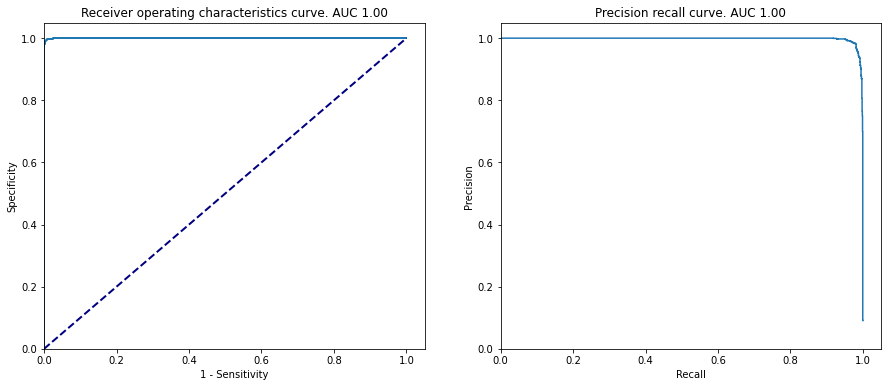

In [6]:
fig, (roc_fig, prc_fig) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
aurocs = []
auprcs = []
for model_name, inferences in model_inferences.items():
    labels = inferences['labels']
    predictions = inferences['predictions']
    fpr, tpr, ft_thresholds = roc_curve(y_true=labels, y_score=predictions)
    positive_predictive_value, sensitivity, pr_thresholds = precision_recall_curve(labels, predictions)
    optimal_roc_idx = np.argmax(tpr - fpr)
    optimal_roc_threshold = ft_thresholds[optimal_roc_idx]
    optimal_prc_idx = np.argmax(sensitivity + positive_predictive_value)
    optimal_prc_threshold = pr_thresholds[optimal_prc_idx]
    auroc = roc_auc_score(y_true=labels, y_score=predictions)
    auprc = average_precision_score(y_true=labels, y_score=predictions)
    aurocs.append(auroc)
    auprcs.append(auprc)

    prc_fig.step(sensitivity, positive_predictive_value, where='post')
    roc_fig.plot(fpr, tpr, lw=2)

roc_fig.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
roc_fig.set_xlim([0.0, 1.05])
roc_fig.set_ylim([0.0, 1.05])
roc_fig.set_xlabel('1 - Sensitivity')
roc_fig.set_ylabel('Specificity')
roc_fig.set_title('Receiver operating characteristics curve. AUC {:.2f}'.format(np.array(aurocs).mean()))

prc_fig.set_xlabel('Recall')
prc_fig.set_ylabel('Precision')
prc_fig.set_ylim([0.0, 1.05])
prc_fig.set_xlim([0.0, 1.05])

prc_fig.set_title("Precision recall curve. AUC {:.2f}".format(np.array(auprcs).mean()))
plt.savefig(os.path.abspath(os.path.expanduser(f"~/catkin_ws/src/rt_gene/assets/rtbene_pytorch_{model_base}_{mode}.pdf")), format="pdf", bbox_inches="tight")
plt.show()

Calculating F-Scores:   0%|          | 0/1000 [00:00<?, ?it/s]

Optimal Threshold from F1-Score Thresholding 0.23


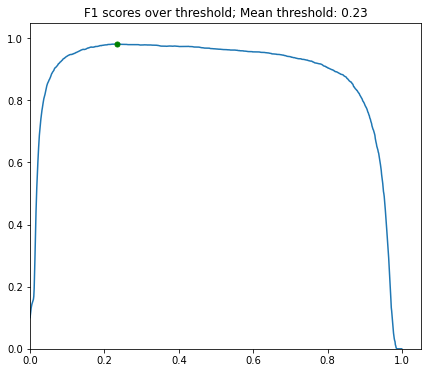

In [7]:
fig, (f1_plot) = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
f1_thresholds = []
for model_name, inferences in model_inferences.items():
    labels = inferences['labels']
    predictions = inferences['predictions']
    thresholds = np.arange(0.0, 1.0, 0.001)
    f1scores = np.zeros(shape=(len(thresholds)))
    # Sweep across the thresholds and calculate the f1-score for those predictions.
    # The idea here is that the threshold with the highest f1-score is ideal
    for index, elem in tqdm(enumerate(thresholds), total=len(thresholds), desc="Calculating F-Scores"):
        # Corrected probabilities
        y_pred_prob = (np.array(predictions) > elem).astype('int')
        # Calculate the f-score
        f1scores[index] = f1_score(np.array(labels), y_pred_prob)

    # Find the optimal threshold
    f1score_argmax_index = np.argmax(f1scores)
    optimal_f1score_threshold = thresholds[f1score_argmax_index]
    f1score_at_optimal_threshold = f1scores[f1score_argmax_index]
    f1_plot.plot(thresholds, f1scores)
    f1_plot.plot(optimal_f1score_threshold, f1score_at_optimal_threshold, color="g", marker="o", markersize=5)
    print(f'Optimal Threshold from F1-Score Thresholding {optimal_f1score_threshold:.2f}')
    f1_thresholds.append(optimal_f1score_threshold)
f1_plot.set_ylim([0.0, 1.05])
f1_plot.set_xlim([0.0, 1.05])
f1_plot.set_title(f"F1 scores over threshold; Mean threshold: {np.array(f1_thresholds).mean():.2f}")
plt.savefig(os.path.abspath(os.path.expanduser(f"~/catkin_ws/src/rt_gene/assets/rtbene_pytorch_f1scores_{model_base}_{mode}.pdf")), format="pdf", bbox_inches="tight")
plt.show()

In [8]:
import pandas as pd
# save the data
for idx, (model_name, inferences) in enumerate(model_inferences.items()):
    labels = inferences['labels']
    predictions = inferences['predictions']
    df = pd.DataFrame({"labels": labels,
                       "predictions": predictions,
                       "model_name": f"{model_base}_{model_name}_{idx}"})
    df.to_csv(os.path.abspath(os.path.expanduser(f"~/catkin_ws/src/rt_gene/assets/rtbene_pytorch_{model_base}_{mode}_{idx}_{augmentation_mode}_{curriculum_mode}.csv")))

In [9]:
# Find some incorrect classification
data_loader = DataLoader(dataset=data_test, batch_size=32, shuffle=False, pin_memory=True, num_workers=8)
model_ensemble = []
for model_file in tqdm(model_files, desc="Loading Models..", position=1):
    model_nn = models.get(model_base)()
    model_nn.load_state_dict(torch.load(model_file))
    model_nn.cuda()
    model_nn.eval()
    model_ensemble.append(model_nn)

labels = []
predictions = []
for batch in tqdm(data_loader, desc="Images...", position=2):
        _left, _right, _label = batch
        _predicted_blink = [sigmoid(m(_left.float().cuda(), _right.float().cuda())) for m in model_ensemble]
        labels.extend(torch.flatten(_label).tolist())
        _predicted_blink = torch.stack(_predicted_blink, dim=1)
        _predicted_blink = torch.mean(_predicted_blink, dim=1)
        predictions.extend(torch.flatten(_predicted_blink.detach().cpu()).tolist())

Loading Models..:   0%|          | 0/1 [00:00<?, ?it/s]

Images...:   0%|          | 0/1002 [00:00<?, ?it/s]

In [10]:
incorrect_predictions_lab = []
incorrect_predictions_pred = []
incorrect_predictions_idx = []
for idx, (lab, pred) in enumerate(zip(labels, predictions)):
    if (lab < 0.1 and pred >= 0.23) or (lab > 0.9 and pred < 0.23):
        incorrect_predictions_lab.append(lab)
        incorrect_predictions_pred.append(pred)
        incorrect_predictions_idx.append(idx)

import pandas as pd
df = pd.DataFrame({"label": incorrect_predictions_lab,
                   "prediction": incorrect_predictions_pred,
                   "index": incorrect_predictions_idx})
df.to_csv(os.path.abspath(os.path.expanduser(f"~/catkin_ws/src/rt_gene/assets/rtbene_pytorch_incorrect_idx.csv")))

In [9]:
# Visualise some incorrect predictions
for label, prediction, idx in zip(incorrect_predictions_lab, incorrect_predictions_pred, incorrect_predictions_idx)
    _img_left, _img_right, _ = data_test[idx]
    _leye_np = np.array(_img_left)
    _reye_np = np.array(_img_right)
    _eye_np = np.concatenate((_reye_np, _leye_np), axis=1)
    _eye_np = cv2.cvtColor(_eye_np, cv2.COLOR_BGR2RGB)
    cv2.imshow("eye", _eye_np)
    cv2.waitKey(1)